In [2]:
import gmplot
import io
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import peakutils 
from peakutils.plot import plot as pplot
import scipy
from math import sqrt
from scipy.integrate import quad
from numpy import trapz
from scipy.integrate import simps
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import chart_studio.plotly as py
import plotly.graph_objs as go
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import operator

The data is collected through the OBD with the help of an app called Torque. The dataset is imported in the form of a csv file.

In [3]:
data = pd.read_csv('dataset.csv')          
data.head()

,GPS Time,Device Time,Longitude,Latitude,GPS Speed (Meters/second),Horizontal Dilution of Precision,Altitude,Bearing,G(x),G(y),...,Trip average MPG(mpg),Trip Distance(km),Trip Time(Since journey start)(s),Trip time(whilst moving)(s),Trip time(whilst stationary)(s),Turbo Boost & Vacuum Gauge(psi),Turbo Pressure Control(psi),Voltage (Control Module)(V),Voltage (OBD Adapter)(V),Volumetric Efficiency (Calculated)(%)
0,Thu Jan 02 16:23:20 GMT+05:30 2020,23:19.7,78.535650,17.341071,0.0,4.288,438.527954,0.0,2.067417,6.272081,...,-,-,0,0.0,0.0,-,-,-,-,-
1,Thu Jan 02 16:23:21 GMT+05:30 2020,23:20.7,78.535650,17.341071,0.0,4.288,438.541382,0.0,1.351169,6.351132,...,-,-,0,0.0,0.0,-9.86256599,-,-,-,-
2,Thu Jan 02 16:23:22 GMT+05:30 2020,23:21.7,78.535649,17.341070,0.0,4.288,438.653809,0.0,1.421836,6.535584,...,-,-,0,0.0,0.0,-9.86256599,-,-,-,-
3,Thu Jan 02 16:23:23 GMT+05:30 2020,23:22.7,78.535649,17.341070,0.0,4.288,438.642822,0.0,0.959509,7.069776,...,-,-,0,0.0,0.0,-9.86256599,-,14.18200016,-,-
4,Thu Jan 02 16:23:24 GMT+05:30 2020,23:23.7,78.535649,17.341070,0.0,4.288,438.828308,0.0,4.199393,4.734184,...,-,-,0,0.0,0.0,-9.86256599,-,14.18200016,14.19999981,-


In [4]:
# Convert the column device time to timestamp
def convert_to_seconds(time_str):
    minutes, seconds = map(float, time_str.split(':'))
    total_seconds = minutes * 60 + seconds
    return total_seconds
time = data[' Device Time'].apply(convert_to_seconds)
Accx = data[' G(x)']
Accy = data[' G(y)']
Accz = data[' G(z)']
latitude = data[' Latitude']
longitude = data[' Longitude']
time

0      1399.7
1      1400.7
2      1401.7
3      1402.7
4      1403.7
        ...  
462    1861.7
463    1862.7
464    1863.7
465    1864.7
466    1865.7
Name:  Device Time, Length: 467, dtype: float64

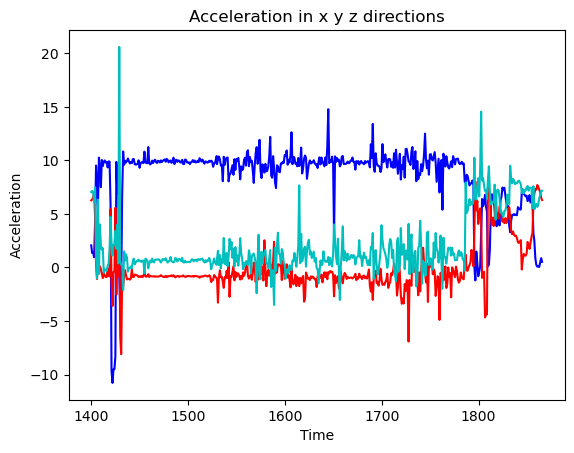

In [5]:
def Plot(x_direction,y_direction,z_direction,Time_parameter,x_label,y_label,plot_title):
  
    plt.figure()
    plt.plot(Time_parameter,x_direction,'b')
    plt.plot(Time_parameter,y_direction,'r')
    plt.plot(Time_parameter,z_direction,'c')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    
Plot(Accx,Accy,Accz,time,'Time','Acceleration','Acceleration in x y z directions')

Plot: This function allows us to plot tri-axial data on a 2D plot. In this case, the data produced by the accelerometer (X Y Z axis) can be plotted in a single plot by passing the parameters to this function.

# Pothole detection

Text(0.5, 1.0, 'Acceleration in y direction')

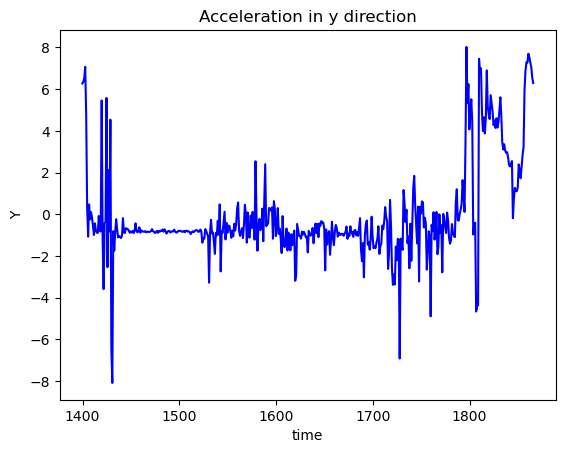

In [6]:
plt.plot(time,Accy,'b')
plt.xlabel('time')
plt.ylabel('Y')
plt.title('Acceleration in y direction')

We need to select points that are the lowest with certain intervals. In this case, thres is set at 0.7 and the min_dist between 2 points is selected at 10. The parameter (-y) iss et so because we need the negatuve peaks in the graph. In order to obtain positive peaks the parameter should be fed as (y).

[ 31 131 328 360 407]
[1430.7 1530.7 1727.7 1759.7 1806.7] [-8.08881187 -3.28108692 -6.91862106 -4.8944416  -4.66447592]


Text(0, 0.5, 'Acceleration in the y direction')

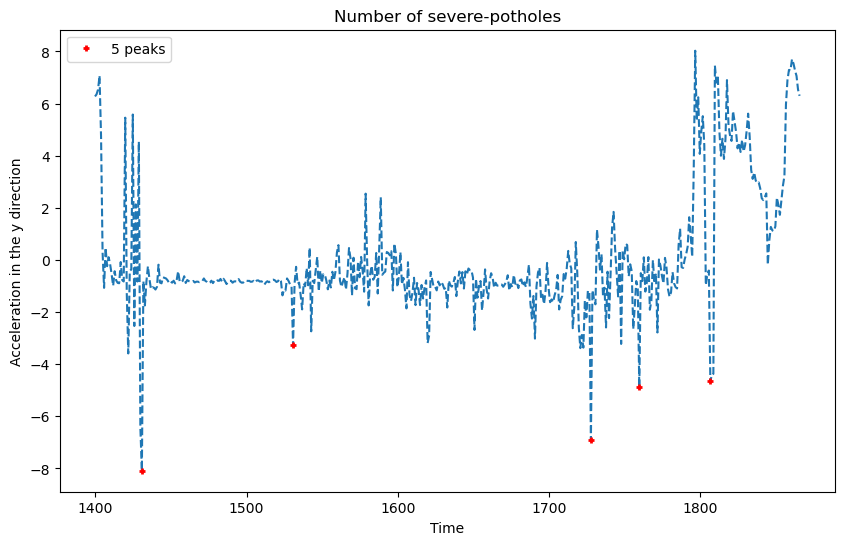

In [7]:
x = np.array(time)
y = np.array(Accy)
indexes = peakutils.indexes(-y, thres=0.7, min_dist=10)
print(indexes)
print(x[indexes], y[indexes])
plt.figure(figsize=(10,6))
pplot(x, y, indexes)
plt.title('Number of severe-potholes')
plt.xlabel('Time')
plt.ylabel('Acceleration in the y direction')

According to the graph, most of the selected points lie below -3. We select latitude longitude form the data with this threshold to map the coordinates.

In [8]:
data[data[' G(y)'] < -3]

,GPS Time,Device Time,Longitude,Latitude,GPS Speed (Meters/second),Horizontal Dilution of Precision,Altitude,Bearing,G(x),G(y),...,Trip average MPG(mpg),Trip Distance(km),Trip Time(Since journey start)(s),Trip time(whilst moving)(s),Trip time(whilst stationary)(s),Turbo Boost & Vacuum Gauge(psi),Turbo Pressure Control(psi),Voltage (Control Module)(V),Voltage (OBD Adapter)(V),Volumetric Efficiency (Calculated)(%)
22,Thu Jan 02 16:23:42 GMT+05:30 2020,23:41.7,78.535699,17.341076,0.00,4.288,432.028442,0.0,-10.780731,-3.588906,...,37.49416733,-,0,0.000000,0.000000,-9.86256599,-,14.20600033,14.19999981,-
30,Thu Jan 02 16:23:50 GMT+05:30 2020,23:49.7,78.535684,17.341075,0.00,4.288,432.772949,0.0,-3.881753,-6.437130,...,35.71099854,-,0,0.000000,0.000000,-8.12211418,-,14.13500023,14.19999981,-
31,Thu Jan 02 16:23:51 GMT+05:30 2020,23:50.7,78.535683,17.341074,0.00,4.288,432.912109,0.0,-1.552151,-8.088812,...,35.58018875,-,0,0.000000,0.000000,-9.86256599,-,14.22900009,14.19999981,-
131,Thu Jan 02 16:25:30 GMT+05:30 2020,25:30.7,78.535698,17.341071,0.42,4.288,423.634827,12.6,10.062327,-3.281087,...,31.05316353,0.00474056,5,5.925000,0.000000,-6.38166094,-,13.3579998,13.39999962,-
220,Thu Jan 02 16:26:59 GMT+05:30 2020,26:59.7,78.532815,17.340935,1.63,3.216,426.322998,208.0,10.156948,-3.190059,...,32.85415268,0.38426062,94,94.903000,0.000000,-7.10684967,-,13.33399963,13.39999962,-
291,Thu Jan 02 16:28:10 GMT+05:30 2020,28:10.7,78.531615,17.341305,2.96,3.216,427.149475,316.9,13.413602,-3.019980,...,30.83390999,0.51403737,165,148.276001,17.629999,-7.54196262,-,14.1590004,14.30000019,-
321,Thu Jan 02 16:28:40 GMT+05:30 2020,28:40.7,78.531170,17.342067,4.03,3.216,424.311951,271.5,9.543705,-3.384093,...,30.86317062,0.63079613,195,178.294998,17.629999,-7.68700027,-,14.06499958,14.19999981,-
323,Thu Jan 02 16:28:42 GMT+05:30 2020,28:42.7,78.531105,17.342082,3.39,3.216,422.823425,318.1,10.346191,-3.366126,...,30.84921074,0.63701564,197,180.307999,17.629999,-5.65647221,-,14.04100037,14.19999981,-
328,Thu Jan 02 16:28:47 GMT+05:30 2020,28:47.7,78.531134,17.342273,4.85,3.216,421.900147,16.0,9.910213,-6.918621,...,30.95046043,0.65817481,202,185.296005,17.629999,-9.86256599,-,14.1590004,14.19999981,-
348,Thu Jan 02 16:29:07 GMT+05:30 2020,29:07.7,78.530661,17.342611,5.14,3.216,417.766724,292.8,9.979683,-3.223596,...,31.08458138,0.73017716,222,205.334000,17.629999,-9.86256599,-,14.18200016,14.19999981,-


# Detection of speed breakers

[  3  25 397 410 422 436 461]
[1402.7 1424.7 1796.7 1809.7 1821.7 1835.7 1860.7] [7.06977606 5.57859039 8.02676964 7.45664549 5.7139349  3.35798168
 7.70218229]


Text(0, 0.5, 'Acceleration in the y direction')

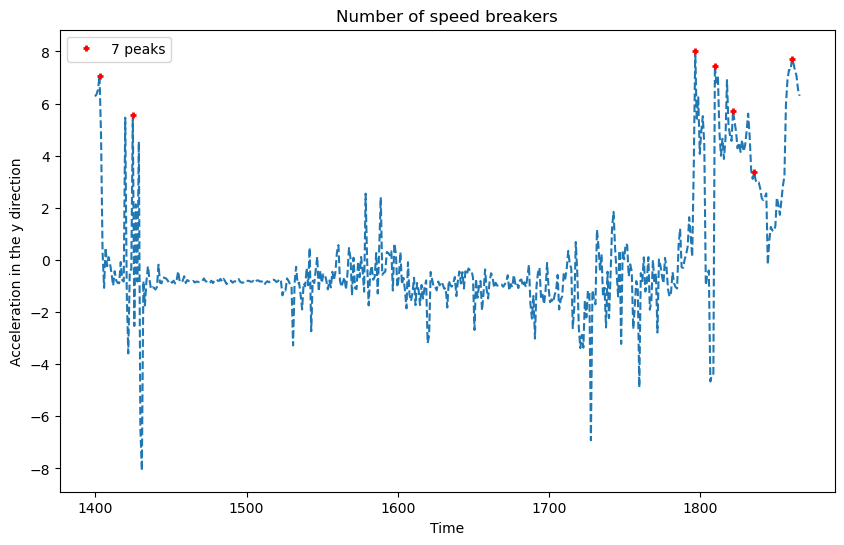

In [9]:
x = np.array(time)
y = np.array(Accy)
indexes = peakutils.indexes(y, thres=0.7, min_dist=10)
print(indexes)
print(x[indexes], y[indexes])
plt.figure(figsize=(10,6))
pplot(x, y, indexes)
plt.title('Number of speed breakers')
plt.xlabel('Time')
plt.ylabel('Acceleration in the y direction')

In [10]:
data[data[' G(y)'] > 4]

,GPS Time,Device Time,Longitude,Latitude,GPS Speed (Meters/second),Horizontal Dilution of Precision,Altitude,Bearing,G(x),G(y),...,Trip average MPG(mpg),Trip Distance(km),Trip Time(Since journey start)(s),Trip time(whilst moving)(s),Trip time(whilst stationary)(s),Turbo Boost & Vacuum Gauge(psi),Turbo Pressure Control(psi),Voltage (Control Module)(V),Voltage (OBD Adapter)(V),Volumetric Efficiency (Calculated)(%)
0,Thu Jan 02 16:23:20 GMT+05:30 2020,23:19.7,78.535650,17.341071,0.00,4.288000,438.527954,0.0,2.067417,6.272081,...,-,-,0,0.000000,0.000000,-,-,-,-,-
1,Thu Jan 02 16:23:21 GMT+05:30 2020,23:20.7,78.535650,17.341071,0.00,4.288000,438.541382,0.0,1.351169,6.351132,...,-,-,0,0.000000,0.000000,-9.86256599,-,-,-,-
2,Thu Jan 02 16:23:22 GMT+05:30 2020,23:21.7,78.535649,17.341070,0.00,4.288000,438.653809,0.0,1.421836,6.535584,...,-,-,0,0.000000,0.000000,-9.86256599,-,-,-,-
3,Thu Jan 02 16:23:23 GMT+05:30 2020,23:22.7,78.535649,17.341070,0.00,4.288000,438.642822,0.0,0.959509,7.069776,...,-,-,0,0.000000,0.000000,-9.86256599,-,14.18200016,-,-
4,Thu Jan 02 16:23:24 GMT+05:30 2020,23:23.7,78.535649,17.341070,0.00,4.288000,438.828308,0.0,4.199393,4.734184,...,-,-,0,0.000000,0.000000,-9.86256599,-,14.18200016,14.19999981,-
20,Thu Jan 02 16:23:40 GMT+05:30 2020,23:39.7,78.535697,17.341076,0.00,5.360000,431.597290,0.0,5.867844,5.457618,...,38.55793381,-,0,0.000000,0.000000,-9.86256599,-,14.1590004,14.30000019,-
25,Thu Jan 02 16:23:45 GMT+05:30 2020,23:44.7,78.535691,17.341075,0.00,4.288000,431.988403,0.0,-8.297818,5.578590,...,36.59171295,-,0,0.000000,0.000000,-8.26715088,-,13.3579998,13.39999962,-
29,Thu Jan 02 16:23:49 GMT+05:30 2020,23:48.7,78.535685,17.341076,0.00,4.288000,432.516296,0.0,-0.692174,4.536557,...,35.8532753,-,0,0.000000,0.000000,-8.12211418,-,14.1590004,14.19999981,-
397,Thu Jan 02 16:29:56 GMT+05:30 2020,29:56.7,78.529948,17.342658,0.00,3.216000,418.826660,0.0,-1.204806,8.026770,...,30.41235352,0.81603032,271,240.664002,31.281000,-7.97707605,-,13.99400043,14,-
398,Thu Jan 02 16:29:57 GMT+05:30 2020,29:57.7,78.529948,17.342658,0.00,3.216000,418.873291,0.0,1.490107,5.343833,...,30.40858269,0.81603032,272,240.664002,32.292999,-7.97707605,-,13.97000027,14.19999981,-


# Video and image processing

In [14]:
import cv2
import time
import numpy as np

def sketch_transform(image):
    # Better sketch transformation function
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    inverted_image = 255 - gray_image
    blurred_image = cv2.GaussianBlur(inverted_image, (21, 21), 0)
    inverted_blur = 255 - blurred_image
    sketch_image = cv2.divide(gray_image, inverted_blur, scale=256.0)
    return sketch_image

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
video_path = 'potholes-video.mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video opened successfully.")
while True:
    r, frame = cap.read()
    if not r:
        break

    start_time = time.time()
    frame = cv2.resize(frame, (1280, 720))  # Downscale to improve frame rate
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # HOG needs a grayscale image

    rects, weights = hog.detectMultiScale(gray_frame)

    # Measure elapsed time for detections
    print("Measure elapsed time for detections")
    end_time = time.time()

    for i, (x, y, w, h) in enumerate(rects):
        if weights[i] < 0.1:
            continue
        # Expand the width and height of the rectangles by a factor
        factor = 1.5  # Adjust this factor as needed
        x_new = int(x - (w * (factor - 1) / 2))
        y_new = int(y - (h * (factor - 1) / 2))
        w_new = int(w * factor)
        h_new = int(h * factor)
        cv2.rectangle(frame, (x_new, y_new), (x_new + w_new, y_new + h_new), (255, 0, 0), 2)  # Blue rectangles for detection

    # Define a larger rectangle to cover most of the frame
    print("Define a larger rectangle to cover most of the frame")
    upper_left = (50, 50)
    bottom_right = (1180, 620)

    # Draw a rectangle marker
    cv2.rectangle(frame, upper_left, bottom_right, (50, 100, 200), 2)
    rect_img = frame[upper_left[1]:bottom_right[1], upper_left[0]:bottom_right[0]]
    print("Draw a rectangle marker")

    # Apply sketch transformation
    sketcher_rect = sketch_transform(rect_img)

    # Conversion for 3 channels to put back on original image (streaming)
    sketcher_rect_rgb = cv2.cvtColor(sketcher_rect, cv2.COLOR_GRAY2RGB)

    # Replacing the sketched image on Region of Interest
    frame[upper_left[1]:bottom_right[1], upper_left[0]:bottom_right[0]] = sketcher_rect_rgb

    # Processing the region for contours
    gray = cv2.cvtColor(rect_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray, 9, 75, 75)  # Changed parameters for better clarity
    edges = cv2.Canny(blur, 50, 150)  # Adjusted thresholds for better edge detection
    ret, thresh_img = cv2.threshold(edges, 91, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        cv2.drawContours(rect_img, [c], -1, (0, 255, 0), 2)  # Thicker green contours

    cv2.imshow("preview", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # press q to quit
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()



Video opened successfully.
Measure elapsed time for detections
Define a larger rectangle to cover most of the frame
Draw a rectangle marker
Measure elapsed time for detections
Define a larger rectangle to cover most of the frame
Draw a rectangle marker
Measure elapsed time for detections
Define a larger rectangle to cover most of the frame
Draw a rectangle marker
Measure elapsed time for detections
Define a larger rectangle to cover most of the frame
Draw a rectangle marker
Measure elapsed time for detections
Define a larger rectangle to cover most of the frame
Draw a rectangle marker
Measure elapsed time for detections
Define a larger rectangle to cover most of the frame
Draw a rectangle marker
Measure elapsed time for detections
Define a larger rectangle to cover most of the frame
Draw a rectangle marker
Measure elapsed time for detections
Define a larger rectangle to cover most of the frame
Draw a rectangle marker
Measure elapsed time for detections
Define a larger rectangle to cove

KeyboardInterrupt: 